Epoch 1/20
200/200 - 1s - loss: 0.0831 - 1s/epoch - 6ms/step
Epoch 2/20
200/200 - 0s - loss: 0.0092 - 261ms/epoch - 1ms/step
Epoch 3/20
200/200 - 0s - loss: 0.0063 - 236ms/epoch - 1ms/step
Epoch 4/20
200/200 - 0s - loss: 0.0044 - 249ms/epoch - 1ms/step
Epoch 5/20
200/200 - 0s - loss: 0.0033 - 272ms/epoch - 1ms/step
Epoch 6/20
200/200 - 0s - loss: 0.0026 - 252ms/epoch - 1ms/step
Epoch 7/20
200/200 - 0s - loss: 0.0021 - 226ms/epoch - 1ms/step
Epoch 8/20
200/200 - 0s - loss: 0.0019 - 243ms/epoch - 1ms/step
Epoch 9/20
200/200 - 0s - loss: 0.0017 - 265ms/epoch - 1ms/step
Epoch 10/20
200/200 - 0s - loss: 0.0016 - 228ms/epoch - 1ms/step
Epoch 11/20
200/200 - 0s - loss: 0.0016 - 222ms/epoch - 1ms/step
Epoch 12/20
200/200 - 0s - loss: 0.0015 - 235ms/epoch - 1ms/step
Epoch 13/20
200/200 - 0s - loss: 0.0015 - 234ms/epoch - 1ms/step
Epoch 14/20
200/200 - 0s - loss: 0.0015 - 237ms/epoch - 1ms/step
Epoch 15/20
200/200 - 0s - loss: 0.0014 - 228ms/epoch - 1ms/step
Epoch 16/20
200/200 - 0s - loss: 0.00

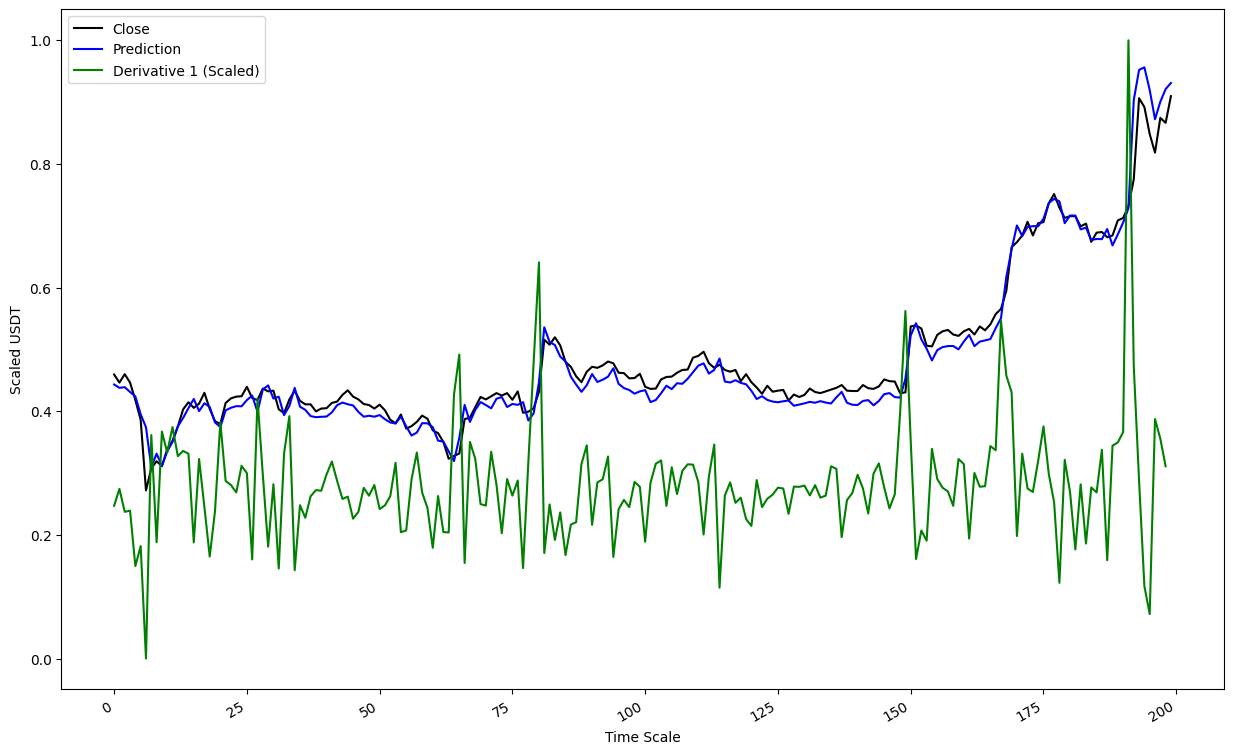

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import constantes as cons

symbol =  str.upper('inj'+'USDT')
client = cons.client

#######################################################################################

timeframe='30m'
historical_data = client.get_historical_klines(symbol, timeframe)
data = pd.DataFrame(historical_data)
data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
data['Open Time'] = pd.to_datetime(data['Open Time']/1000, unit='s')
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis=1)
data['timestamp']=data['Open Time']
data.set_index('timestamp', inplace=True)

data.dropna(inplace=True)
data.drop(['Open Time','Close Time','Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume','Number of Trades',
          'Ignore'], axis=1, inplace=True)
stock_data = data
pd.set_option('display.max_columns', None)

############################################################################################

X_feat = stock_data.iloc[:,0:3]
#X_ft = StandardScaler().fit_transform(X_feat.values)

X_ft = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,data=X_ft,index=X_feat.index)

def ltsm_split (data,n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps+1):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps-1, -1])
    return np.array(X),np.array(y)

n_steps=1
X1, y1 = ltsm_split(X_ft.values, n_steps=n_steps)

train_split =0.8
split_idx = int(np.ceil(len(X1)*train_split))

X_train , X_test = X1[:split_idx], X1[split_idx:]
y_train , y_test = y1[:split_idx], y1[split_idx:]

lstm=Sequential()
lstm.add(LSTM(32,input_shape=(X_train.shape[1],X_train.shape[2]),activation='relu',return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')

lstm.fit(X_train,y_train,epochs=20,batch_size=4,verbose=2,shuffle=False)

y_pred = lstm.predict(X_test)
# Calcular las derivadas
deriv_y_pred = np.diff(y_pred, axis=0)
deriv_y_pred2 = np.diff(deriv_y_pred, axis=0)
# Ajustar la forma de deriv_y_pred
deriv_y_pred = deriv_y_pred.reshape(-1, 1)
deriv_y_pred2 = deriv_y_pred2.reshape(-1, 1)
# Escalar las derivadas
scaler1 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled = scaler1.fit_transform(deriv_y_pred)
scaler2 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled2 = scaler2.fit_transform(deriv_y_pred2)

#grafica
plt.figure(figsize=(15, 10))
plt.plot(y_test, label='Close',color = 'black')
time_index = range(n_steps-1, n_steps-1+len(y_pred))
plt.plot(time_index, y_pred[:, -1, 0], label='Prediction',color = 'blue')
plt.plot(time_index[:-1], deriv_y_pred_scaled[:, 0], label='Derivative 1 (Scaled)',color = 'green')
#plt.plot(time_index[:-2], deriv_y_pred_scaled2[:, 0], label='Derivative 2 (Scaled)',color = 'red')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USDT')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
